In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils & preprocess

X = (batch, sequence, dimension)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [2]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [3]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [4]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [6]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [9]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [10]:
class Embedding(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.position_embeddings = nn.Embedding(config.sequence_length, config.input_feature)
    self.norm_layer = nn.LayerNorm(config.input_feature , eps=1e-12)
    self.dropout = nn.Dropout()

  def forward(self, input_tensor):
      device = input_tensor.device  # input_tensor의 디바이스를 가져옵니다.
      input_pos = torch.arange(input_tensor.size(1), dtype=torch.long, device=device)  # 디바이스를 지정하여 input_pos를 생성합니다.
      pos_emb = self.position_embeddings(input_pos).unsqueeze(0)
      final_emb = input_tensor + pos_emb
      final_emb = self.norm_layer(final_emb)
      final_emb = self.dropout(final_emb)
      return final_emb

In [11]:
from math import sqrt
def scaled_dot_product(query,key,value):
  dim_k = query.size(-1)
  similiarity = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)
  similiarity = F.softmax(similiarity, dim = -1) #여기 조심하자
  return torch.bmm(similiarity,value)

In [12]:
class Attention_head(nn.Module):
  def __init__(self, emb_dim, head_dim):
    super().__init__()
    self.query = nn.Linear(emb_dim, head_dim)
    self.key = nn.Linear(emb_dim, head_dim)
    self.value = nn.Linear(emb_dim, head_dim)

  def forward(self, final_emb):
    q = self.query(final_emb)
    k = self.key(final_emb)
    v = self.value(final_emb)
    return scaled_dot_product(q, k, v)

In [13]:
class Multihead_attention(nn.Module):
  def __init__(self,config):
    super().__init__()
    input_feature = config.input_feature
    self.attention_heads = nn.ModuleList([Attention_head(input_feature,4),
                                          Attention_head(input_feature,4),
                                          Attention_head(input_feature,4),
                                          Attention_head(input_feature,4),
                                          Attention_head(input_feature,3)])
    self.dense_layer = nn.Linear(input_feature, input_feature)

  def forward(self, final_emb):
    x = torch.cat([h(final_emb) for h in self.attention_heads],dim = -1)
    x = self.dense_layer(x)
    return x

In [14]:
class Feedforward(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.layer1 = nn.Linear(config.input_feature, config.feed_foward_dim)
    self.layer2 = nn.Linear(config.feed_foward_dim, config.input_feature)
    self.gelu = nn.GELU()
    self.dropout = nn.Dropout()

  def forward(self, x):
    x = self.layer1(x)
    x = self.gelu(x)
    x = self.layer2(x)
    x = self.dropout(x)
    return x

In [15]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.Norm1 = nn.LayerNorm(config.input_feature)
    self.Norm2 = nn.LayerNorm(config.input_feature)
    self.attention = Multihead_attention(config)
    self.feedforward = Feedforward(config)

  def forward(self,x):
    norm = self.Norm1(x)
    x = x + self.attention(norm)
    x = x + self.feedforward(self.Norm2(x))
    return x

In [16]:
class AttentionMechanism(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        dim_k = q.size(-1)

        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / (dim_k ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)

        weighted_average = torch.matmul(attention_weights, x)

        return weighted_average.mean(dim=1)

In [17]:
class TransformerEncoder(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.embedding = Embedding(config)
    self.layers = nn.ModuleList([TransformerEncoderLayer(config) for i in range(config.num_layers)])
    self.attention = AttentionMechanism(config.input_feature)
    self.classifier = nn.Linear(config.input_feature, 2)

  def forward(self,x):
    x = self.embedding(x)
    for layer in self.layers:
      x = layer(x)
    x = self.attention(x)
    x = self.classifier(x)
    return x

# trainer 구현

In [18]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [19]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 5000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  input_feature = 19     # input feature 이거 바꾸면 모델 안 돌아감
  feed_foward_dim = 100  # feed forward dimension
  num_layers = 12        # encoder block 개수

config = Config()

In [20]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [21]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [22]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


In [23]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 5000
failure(1)의 개수 : 1569


In [24]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [25]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [26]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [27]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 3941
Total number of data samples in valid_loader: 1313
Total number of data samples in test_loader: 1314


In [28]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=1)

In [29]:
# model, optimizer, loss_function 구현하고 결합시키기
model = TransformerEncoder(config)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [31]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/5000_Transformer') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 6/6 [00:00<00:00, 44.33it/s]


Model saved
TRAIN LOSS = 0.0024527167342272365, TRAIN ACC = 0.7236741943669119, 
VALID LOSS = 0.0022534382361450544, VALID ACC = 0.7661843107387661, 
epoch 2


100%|██████████| 6/6 [00:00<00:00, 75.82it/s]


Model saved
TRAIN LOSS = 0.002035606749860565, TRAIN ACC = 0.7726465364120781, 
VALID LOSS = 0.002153403642789517, VALID ACC = 0.8027418126428028, 
epoch 3


100%|██████████| 6/6 [00:00<00:00, 72.86it/s]


TRAIN LOSS = 0.0019882260633888233, TRAIN ACC = 0.7794975894443035, 
VALID LOSS = 0.002151463427619905, VALID ACC = 0.776085300837776, 
epoch 4


100%|██████████| 6/6 [00:00<00:00, 81.24it/s]


TRAIN LOSS = 0.0019264322901945735, TRAIN ACC = 0.7807663029687897, 
VALID LOSS = 0.002321455011999707, VALID ACC = 0.7372429550647372, 
epoch 5


100%|██████████| 6/6 [00:00<00:00, 82.94it/s]


TRAIN LOSS = 0.001865301722652626, TRAIN ACC = 0.7896472976401928, 
VALID LOSS = 0.002063268436699175, VALID ACC = 0.7738004569687738, 
epoch 6


100%|██████████| 6/6 [00:00<00:00, 66.34it/s]


TRAIN LOSS = 0.0018268028995888513, TRAIN ACC = 0.7899010403450901, 
VALID LOSS = 0.002298379865931085, VALID ACC = 0.7570449352627571, 
epoch 7


100%|██████████| 6/6 [00:00<00:00, 83.36it/s]


TRAIN LOSS = 0.0017783715772737678, TRAIN ACC = 0.7853336716569399, 
VALID LOSS = 0.002053086279188506, VALID ACC = 0.7783701447067783, 
epoch 8


100%|██████████| 6/6 [00:00<00:00, 79.26it/s]


TRAIN LOSS = 0.0017779002755887918, TRAIN ACC = 0.7901547830499873, 
VALID LOSS = 0.002147846769396803, VALID ACC = 0.7821782178217822, 
epoch 9


100%|██████████| 6/6 [00:00<00:00, 82.52it/s]


TRAIN LOSS = 0.0017764339574670102, TRAIN ACC = 0.7931996955087541, 
VALID LOSS = 0.0019481782911392176, VALID ACC = 0.7776085300837776, 
epoch 10


100%|██████████| 6/6 [00:00<00:00, 82.04it/s]


TRAIN LOSS = 0.0017229723494780666, TRAIN ACC = 0.7926922100989596, 
VALID LOSS = 0.0020598204237581297, VALID ACC = 0.7882711348057883, 
epoch 11


100%|██████████| 6/6 [00:00<00:00, 82.02it/s]


TRAIN LOSS = 0.0017341401364651466, TRAIN ACC = 0.7980208069018015, 
VALID LOSS = 0.002148287085658798, VALID ACC = 0.7776085300837776, 
epoch 12


100%|██████████| 6/6 [00:00<00:00, 79.43it/s]


TRAIN LOSS = 0.001718785724371286, TRAIN ACC = 0.7959908652626237, 
VALID LOSS = 0.0021115001021499227, VALID ACC = 0.7897943640517898, 
epoch 13


100%|██████████| 6/6 [00:00<00:00, 83.28it/s]


TRAIN LOSS = 0.0016789198057871125, TRAIN ACC = 0.8043643745242324, 
VALID LOSS = 0.002189457416534424, VALID ACC = 0.7776085300837776, 
epoch 14


100%|██████████| 6/6 [00:00<00:00, 74.24it/s]


TRAIN LOSS = 0.001657560516873824, TRAIN ACC = 0.8053793453438214, 
VALID LOSS = 0.0018768614017591165, VALID ACC = 0.801980198019802, 
epoch 15


100%|██████████| 6/6 [00:00<00:00, 78.05it/s]


TRAIN LOSS = 0.0017073395681151337, TRAIN ACC = 0.7992895204262878, 
VALID LOSS = 0.002126760139596072, VALID ACC = 0.7958872810357959, 
epoch 16


100%|██████████| 6/6 [00:00<00:00, 76.92it/s]


TRAIN LOSS = 0.0016768711967173036, TRAIN ACC = 0.8053793453438214, 
VALID LOSS = 0.0021896840095156854, VALID ACC = 0.7829398324447829, 
epoch 17


100%|██████████| 6/6 [00:00<00:00, 77.65it/s]


TRAIN LOSS = 0.001661565038523254, TRAIN ACC = 0.8109616848515605, 
VALID LOSS = 0.001871565213570228, VALID ACC = 0.7958872810357959, 
epoch 18


100%|██████████| 6/6 [00:00<00:00, 71.76it/s]


TRAIN LOSS = 0.001674005999476799, TRAIN ACC = 0.7990357777213906, 
VALID LOSS = 0.002097911514222667, VALID ACC = 0.776085300837776, 
epoch 19


100%|██████████| 6/6 [00:00<00:00, 82.35it/s]


Model saved
TRAIN LOSS = 0.0016259761577752361, TRAIN ACC = 0.8129916264907384, 
VALID LOSS = 0.002098413137470777, VALID ACC = 0.8042650418888042, 
epoch 20


100%|██████████| 6/6 [00:00<00:00, 82.42it/s]


Model saved
TRAIN LOSS = 0.0016238668248666117, TRAIN ACC = 0.8069018015732048, 
VALID LOSS = 0.0017869471141789038, VALID ACC = 0.8126428027418127, 
epoch 21


100%|██████████| 6/6 [00:00<00:00, 83.12it/s]


TRAIN LOSS = 0.001588019969892272, TRAIN ACC = 0.814767825425019, 
VALID LOSS = 0.002068486907331433, VALID ACC = 0.801980198019802, 
epoch 22


100%|██████████| 6/6 [00:00<00:00, 83.87it/s]


TRAIN LOSS = 0.0015857517492405143, TRAIN ACC = 0.8086780005074854, 
VALID LOSS = 0.0019082875308060773, VALID ACC = 0.8088347296268088, 
epoch 23


100%|██████████| 6/6 [00:00<00:00, 82.12it/s]


Model saved
TRAIN LOSS = 0.0015380015699308677, TRAIN ACC = 0.8188277087033747, 
VALID LOSS = 0.001775458398341043, VALID ACC = 0.8134044173648134, 
epoch 24


100%|██████████| 6/6 [00:00<00:00, 82.19it/s]


TRAIN LOSS = 0.001567503857570262, TRAIN ACC = 0.8173052524739913, 
VALID LOSS = 0.002053994603131622, VALID ACC = 0.7661843107387661, 
epoch 25


100%|██████████| 6/6 [00:00<00:00, 81.56it/s]


TRAIN LOSS = 0.001548255073694492, TRAIN ACC = 0.8213651357523472, 
VALID LOSS = 0.0020579521154867088, VALID ACC = 0.7776085300837776, 
epoch 26


100%|██████████| 6/6 [00:00<00:00, 81.86it/s]


TRAIN LOSS = 0.0015496750889439112, TRAIN ACC = 0.822380106571936, 
VALID LOSS = 0.0018199111837879538, VALID ACC = 0.7936024371667936, 
epoch 27


100%|██████████| 6/6 [00:00<00:00, 81.49it/s]


TRAIN LOSS = 0.001497662897734314, TRAIN ACC = 0.8231413346866278, 
VALID LOSS = 0.002129105080744735, VALID ACC = 0.7448591012947449, 
epoch 28


100%|██████████| 6/6 [00:00<00:00, 79.52it/s]


TRAIN LOSS = 0.001490628112847658, TRAIN ACC = 0.8216188784572444, 
VALID LOSS = 0.0020780054013963337, VALID ACC = 0.763899466869764, 
epoch 29


100%|██████████| 6/6 [00:00<00:00, 81.24it/s]


TRAIN LOSS = 0.0014872349509428189, TRAIN ACC = 0.8249175336209084, 
VALID LOSS = 0.0020168949108675793, VALID ACC = 0.7837014470677837, 
epoch 30


100%|██████████| 6/6 [00:00<00:00, 81.80it/s]


Model saved
TRAIN LOSS = 0.00145692230632117, TRAIN ACC = 0.8264399898502918, 
VALID LOSS = 0.0016581362563058428, VALID ACC = 0.8194973343488196, 
epoch 31


100%|██████████| 6/6 [00:00<00:00, 78.80it/s]


TRAIN LOSS = 0.0014443969445251566, TRAIN ACC = 0.8299923877188531, 
VALID LOSS = 0.0017322740614731985, VALID ACC = 0.801980198019802, 
epoch 32


100%|██████████| 6/6 [00:00<00:00, 81.96it/s]


TRAIN LOSS = 0.001425965928511098, TRAIN ACC = 0.8332910428825171, 
VALID LOSS = 0.001992353458760444, VALID ACC = 0.7753236862147753, 
epoch 33


100%|██████████| 6/6 [00:00<00:00, 73.17it/s]


TRAIN LOSS = 0.0014403369698358713, TRAIN ACC = 0.8335447855874144, 
VALID LOSS = 0.0023031595864553807, VALID ACC = 0.7364813404417365, 
epoch 34


100%|██████████| 6/6 [00:00<00:00, 80.47it/s]


Model saved
TRAIN LOSS = 0.0014528613788045261, TRAIN ACC = 0.832022329358031, 
VALID LOSS = 0.0016008539228882393, VALID ACC = 0.8362528560548362, 
epoch 35


100%|██████████| 6/6 [00:00<00:00, 81.73it/s]


TRAIN LOSS = 0.0013595010931193603, TRAIN ACC = 0.8373509261608729, 
VALID LOSS = 0.0020616066337812065, VALID ACC = 0.7646610814927647, 
epoch 36


100%|██████████| 6/6 [00:00<00:00, 61.87it/s]


TRAIN LOSS = 0.0013457880471449035, TRAIN ACC = 0.8398883532098452, 
VALID LOSS = 0.0020784490315494696, VALID ACC = 0.7494287890327495, 
epoch 37


100%|██████████| 6/6 [00:00<00:00, 82.00it/s]


TRAIN LOSS = 0.0013677672107520367, TRAIN ACC = 0.8363359553412839, 
VALID LOSS = 0.0017988531306238457, VALID ACC = 0.821020563594821, 
epoch 38


100%|██████████| 6/6 [00:00<00:00, 82.19it/s]


TRAIN LOSS = 0.0013617705010242555, TRAIN ACC = 0.8454706927175843, 
VALID LOSS = 0.002295198984393071, VALID ACC = 0.7425742574257426, 
epoch 39


100%|██████████| 6/6 [00:00<00:00, 81.94it/s]


TRAIN LOSS = 0.0013517188151697616, TRAIN ACC = 0.8411570667343314, 
VALID LOSS = 0.0017800335655299563, VALID ACC = 0.7981721249047982, 
epoch 40


100%|██████████| 6/6 [00:00<00:00, 76.24it/s]


TRAIN LOSS = 0.0013719973180597127, TRAIN ACC = 0.8378584115706673, 
VALID LOSS = 0.002017858504159525, VALID ACC = 0.7989337395277989, 
epoch 41


100%|██████████| 6/6 [00:00<00:00, 79.99it/s]


TRAIN LOSS = 0.0012779749572594677, TRAIN ACC = 0.846231920832276, 
VALID LOSS = 0.0018527699579106698, VALID ACC = 0.7882711348057883, 
epoch 42


100%|██████████| 6/6 [00:00<00:00, 78.33it/s]


TRAIN LOSS = 0.0013157459676825314, TRAIN ACC = 0.8467394062420706, 
VALID LOSS = 0.002076770908852524, VALID ACC = 0.773038842345773, 
epoch 43


100%|██████████| 6/6 [00:00<00:00, 91.26it/s]


TRAIN LOSS = 0.0012670574613828642, TRAIN ACC = 0.8581578279624461, 
VALID LOSS = 0.0018762841718576377, VALID ACC = 0.7905559786747905, 
epoch 44


100%|██████████| 6/6 [00:00<00:00, 84.47it/s]


TRAIN LOSS = 0.0013121542395809766, TRAIN ACC = 0.8510530322253235, 
VALID LOSS = 0.0018766859244138162, VALID ACC = 0.7966488956587966, 
epoch 45


100%|██████████| 6/6 [00:00<00:00, 84.32it/s]


TRAIN LOSS = 0.0013118851565975915, TRAIN ACC = 0.8500380614057346, 
VALID LOSS = 0.0018674055992512874, VALID ACC = 0.8248286367098249, 
epoch 46


100%|██████████| 6/6 [00:00<00:00, 81.43it/s]


TRAIN LOSS = 0.0013467705331457293, TRAIN ACC = 0.8457244354224817, 
VALID LOSS = 0.002016380417918941, VALID ACC = 0.8057882711348058, 
epoch 47


100%|██████████| 6/6 [00:00<00:00, 84.64it/s]


TRAIN LOSS = 0.0012812496169331534, TRAIN ACC = 0.8535904592742959, 
VALID LOSS = 0.0016468908731390843, VALID ACC = 0.824067022086824, 
epoch 48


100%|██████████| 6/6 [00:00<00:00, 74.99it/s]


TRAIN LOSS = 0.0012722082456880582, TRAIN ACC = 0.855874143618371, 
VALID LOSS = 0.0021820746799143596, VALID ACC = 0.776085300837776, 
epoch 49


100%|██████████| 6/6 [00:00<00:00, 84.04it/s]


TRAIN LOSS = 0.0012629743768490683, TRAIN ACC = 0.8505455468155291, 
VALID LOSS = 0.001988608126229942, VALID ACC = 0.7996953541507997, 
epoch 50


100%|██████████| 6/6 [00:00<00:00, 84.48it/s]


TRAIN LOSS = 0.0012494253419553286, TRAIN ACC = 0.8530829738645014, 
VALID LOSS = 0.002120006020888062, VALID ACC = 0.7768469154607769, 
epoch 51


100%|██████████| 6/6 [00:00<00:00, 83.44it/s]


TRAIN LOSS = 0.0012400127990812675, TRAIN ACC = 0.8530829738645014, 
VALID LOSS = 0.0019520653719586085, VALID ACC = 0.8088347296268088, 
epoch 52


100%|██████████| 6/6 [00:00<00:00, 81.79it/s]


TRAIN LOSS = 0.0012230914850823015, TRAIN ACC = 0.8612027404212129, 
VALID LOSS = 0.0018982177278238312, VALID ACC = 0.8073115003808073, 
epoch 53


100%|██████████| 6/6 [00:00<00:00, 82.84it/s]


TRAIN LOSS = 0.00118771721735366, TRAIN ACC = 0.8609489977163156, 
VALID LOSS = 0.0018864774286338416, VALID ACC = 0.7867479055597868, 
epoch 54


100%|██████████| 6/6 [00:00<00:00, 82.40it/s]


TRAIN LOSS = 0.0012236956834974582, TRAIN ACC = 0.8540979446840903, 
VALID LOSS = 0.0019491367547092597, VALID ACC = 0.7897943640517898, 
epoch 55


100%|██████████| 6/6 [00:00<00:00, 79.12it/s]


TRAIN LOSS = 0.001258014952038424, TRAIN ACC = 0.8553666582085765, 
VALID LOSS = 0.001882527293091227, VALID ACC = 0.814927646610815, 
epoch 56


100%|██████████| 6/6 [00:00<00:00, 74.17it/s]


TRAIN LOSS = 0.0011939135217267345, TRAIN ACC = 0.8629789393554935, 
VALID LOSS = 0.002008360256607625, VALID ACC = 0.7989337395277989, 
epoch 57


100%|██████████| 6/6 [00:00<00:00, 74.30it/s]


TRAIN LOSS = 0.0012016089751737972, TRAIN ACC = 0.8581578279624461, 
VALID LOSS = 0.0023452427354552596, VALID ACC = 0.763899466869764, 
epoch 58


100%|██████████| 6/6 [00:00<00:00, 83.04it/s]


TRAIN LOSS = 0.0012016218421242015, TRAIN ACC = 0.8563816290281654, 
VALID LOSS = 0.0025134388944708656, VALID ACC = 0.7600913937547601, 
epoch 59


100%|██████████| 6/6 [00:00<00:00, 79.90it/s]


TRAIN LOSS = 0.001170188937202924, TRAIN ACC = 0.8690687642730272, 
VALID LOSS = 0.002167690236061834, VALID ACC = 0.8095963442498096, 
epoch 60


100%|██████████| 6/6 [00:00<00:00, 78.37it/s]


TRAIN LOSS = 0.0011797983901690057, TRAIN ACC = 0.8695762496828217, 
VALID LOSS = 0.0022768881923809184, VALID ACC = 0.7943640517897944, 
epoch 61


100%|██████████| 6/6 [00:00<00:00, 77.74it/s]


TRAIN LOSS = 0.0011956589728918997, TRAIN ACC = 0.8614564831261101, 
VALID LOSS = 0.0025980225384734735, VALID ACC = 0.773038842345773, 
epoch 62


100%|██████████| 6/6 [00:00<00:00, 79.64it/s]


TRAIN LOSS = 0.0011450049085261343, TRAIN ACC = 0.8703374777975134, 
VALID LOSS = 0.0025584638254931204, VALID ACC = 0.7966488956587966, 
epoch 63


100%|██████████| 6/6 [00:00<00:00, 82.24it/s]


TRAIN LOSS = 0.001179859072416151, TRAIN ACC = 0.8657701091093631, 
VALID LOSS = 0.002234861402228327, VALID ACC = 0.7951256664127951, 
epoch 64


100%|██████████| 6/6 [00:00<00:00, 82.99it/s]


TRAIN LOSS = 0.0011467884727856495, TRAIN ACC = 0.876427302715047, 
VALID LOSS = 0.002021465424990164, VALID ACC = 0.8080731150038081, 
epoch 65


100%|██████████| 6/6 [00:00<00:00, 79.10it/s]


TRAIN LOSS = 0.0011060739366634943, TRAIN ACC = 0.8713524486171023, 
VALID LOSS = 0.001980806761176552, VALID ACC = 0.8042650418888042, 
epoch 66


100%|██████████| 6/6 [00:00<00:00, 82.44it/s]


TRAIN LOSS = 0.0010879682885060846, TRAIN ACC = 0.8716061913219995, 
VALID LOSS = 0.002520405329190768, VALID ACC = 0.7905559786747905, 
epoch 67


100%|██████████| 6/6 [00:00<00:00, 82.96it/s]


TRAIN LOSS = 0.0011216565698150814, TRAIN ACC = 0.8771885308297387, 
VALID LOSS = 0.0020293593406677246, VALID ACC = 0.785986290936786, 
epoch 68


100%|██████████| 6/6 [00:00<00:00, 82.08it/s]


TRAIN LOSS = 0.0011314156242386094, TRAIN ACC = 0.872113676731794, 
VALID LOSS = 0.0018205810664540833, VALID ACC = 0.824067022086824, 
epoch 69


100%|██████████| 6/6 [00:00<00:00, 81.09it/s]


TRAIN LOSS = 0.0010725569185101118, TRAIN ACC = 0.8792184724689165, 
VALID LOSS = 0.001863084285202956, VALID ACC = 0.817974105102818, 
epoch 70


100%|██████████| 6/6 [00:00<00:00, 81.13it/s]


TRAIN LOSS = 0.001092662494577632, TRAIN ACC = 0.8751585891905608, 
VALID LOSS = 0.002016410742292673, VALID ACC = 0.8164508758568164, 
epoch 71


100%|██████████| 6/6 [00:00<00:00, 83.87it/s]


TRAIN LOSS = 0.00105416017025142, TRAIN ACC = 0.8807409286982999, 
VALID LOSS = 0.0018356771684292156, VALID ACC = 0.817974105102818, 
epoch 72


100%|██████████| 6/6 [00:00<00:00, 82.39it/s]


TRAIN LOSS = 0.00107955767006718, TRAIN ACC = 0.8779497589444304, 
VALID LOSS = 0.0024051318982132317, VALID ACC = 0.7936024371667936, 
epoch 73


100%|██████████| 6/6 [00:00<00:00, 78.56it/s]


TRAIN LOSS = 0.0010761086392057817, TRAIN ACC = 0.8733823902562802, 
VALID LOSS = 0.0021999154668315532, VALID ACC = 0.7958872810357959, 
epoch 74


100%|██████████| 6/6 [00:00<00:00, 82.87it/s]


TRAIN LOSS = 0.0010632543931664382, TRAIN ACC = 0.8771885308297387, 
VALID LOSS = 0.0023128894205231387, VALID ACC = 0.7913175932977913, 
epoch 75


100%|██████████| 6/6 [00:00<00:00, 83.13it/s]


TRAIN LOSS = 0.0010557716243976688, TRAIN ACC = 0.8853082973864501, 
VALID LOSS = 0.0021608190643633038, VALID ACC = 0.8012185833968012, 
epoch 76


100%|██████████| 6/6 [00:00<00:00, 82.77it/s]


TRAIN LOSS = 0.0010598537712283498, TRAIN ACC = 0.8855620400913474, 
VALID LOSS = 0.002271043804884865, VALID ACC = 0.8042650418888042, 
epoch 77


100%|██████████| 6/6 [00:00<00:00, 80.26it/s]


TRAIN LOSS = 0.0011304726125140748, TRAIN ACC = 0.872113676731794, 
VALID LOSS = 0.0020294956868600954, VALID ACC = 0.801980198019802, 
epoch 78


100%|██████████| 6/6 [00:00<00:00, 79.85it/s]


TRAIN LOSS = 0.0011210347629990924, TRAIN ACC = 0.8749048464856636, 
VALID LOSS = 0.0021134384787908876, VALID ACC = 0.8065498857578065, 
epoch 79


100%|██████████| 6/6 [00:00<00:00, 83.83it/s]


TRAIN LOSS = 0.0010178409057412467, TRAIN ACC = 0.8850545546815529, 
VALID LOSS = 0.0025048708970185373, VALID ACC = 0.8141660319878141, 
epoch 80


100%|██████████| 6/6 [00:00<00:00, 84.27it/s]


TRAIN LOSS = 0.001047073441149468, TRAIN ACC = 0.8837858411570667, 
VALID LOSS = 0.0024596964323329996, VALID ACC = 0.7920792079207921, 
epoch 81


100%|██████████| 6/6 [00:00<00:00, 49.74it/s]


TRAIN LOSS = 0.0010732851584107099, TRAIN ACC = 0.8807409286982999, 
VALID LOSS = 0.0025630098259004125, VALID ACC = 0.8141660319878141, 
epoch 82


100%|██████████| 6/6 [00:00<00:00, 80.11it/s]


TRAIN LOSS = 0.0010878912569514025, TRAIN ACC = 0.8804871859934027, 
VALID LOSS = 0.001966161870447988, VALID ACC = 0.8278750952018279, 
epoch 83


100%|██████████| 6/6 [00:00<00:00, 80.13it/s]


TRAIN LOSS = 0.0010282954787639337, TRAIN ACC = 0.8842933265668612, 
VALID LOSS = 0.0026652090711077932, VALID ACC = 0.789032749428789, 
epoch 84


100%|██████████| 6/6 [00:00<00:00, 81.28it/s]


TRAIN LOSS = 0.0009825288553704952, TRAIN ACC = 0.8957117482872368, 
VALID LOSS = 0.0020420178146827155, VALID ACC = 0.805026656511805, 
epoch 85


100%|██████████| 6/6 [00:00<00:00, 73.67it/s]


TRAIN LOSS = 0.000997639264258235, TRAIN ACC = 0.8919056077137782, 
VALID LOSS = 0.001981880632140486, VALID ACC = 0.8202589489718203, 
epoch 86


100%|██████████| 6/6 [00:00<00:00, 68.01it/s]


TRAIN LOSS = 0.0010120955836316167, TRAIN ACC = 0.887338239025628, 
VALID LOSS = 0.0025034189814388164, VALID ACC = 0.8088347296268088, 
epoch 87


100%|██████████| 6/6 [00:00<00:00, 77.68it/s]


TRAIN LOSS = 0.0010208070686522307, TRAIN ACC = 0.8880994671403197, 
VALID LOSS = 0.002681347448591594, VALID ACC = 0.7928408225437928, 
epoch 88


100%|██████████| 6/6 [00:00<00:00, 75.47it/s]


TRAIN LOSS = 0.0010197414862749632, TRAIN ACC = 0.8858157827962446, 
VALID LOSS = 0.0019265500217199507, VALID ACC = 0.8095963442498096, 
epoch 89


100%|██████████| 6/6 [00:00<00:00, 46.12it/s]


TRAIN LOSS = 0.000937940913449384, TRAIN ACC = 0.8990104034509008, 
VALID LOSS = 0.0030595568510202262, VALID ACC = 0.7753236862147753, 
epoch 90


100%|██████████| 6/6 [00:00<00:00, 82.90it/s]


TRAIN LOSS = 0.0010149388960913575, TRAIN ACC = 0.8921593504186754, 
VALID LOSS = 0.002643715263956481, VALID ACC = 0.7837014470677837, 
epoch 91


100%|██████████| 6/6 [00:00<00:00, 82.70it/s]


TRAIN LOSS = 0.0009544714434562495, TRAIN ACC = 0.8997716315655925, 
VALID LOSS = 0.002333514057582149, VALID ACC = 0.8172124904798173, 
epoch 92


100%|██████████| 6/6 [00:00<00:00, 74.39it/s]


TRAIN LOSS = 0.0010080512474104101, TRAIN ACC = 0.8946967774676478, 
VALID LOSS = 0.002387081609821828, VALID ACC = 0.7936024371667936, 
epoch 93


100%|██████████| 6/6 [00:00<00:00, 74.50it/s]


TRAIN LOSS = 0.0009968016836371587, TRAIN ACC = 0.8936818066480589, 
VALID LOSS = 0.0020611584073064533, VALID ACC = 0.8088347296268088, 
epoch 94


100%|██████████| 6/6 [00:00<00:00, 82.45it/s]


TRAIN LOSS = 0.0009809494457157758, TRAIN ACC = 0.8977416899264146, 
VALID LOSS = 0.002704302976808744, VALID ACC = 0.7913175932977913, 
epoch 95


100%|██████████| 6/6 [00:00<00:00, 83.85it/s]


TRAIN LOSS = 0.0009590958435805852, TRAIN ACC = 0.8954580055823395, 
VALID LOSS = 0.0023869429938410043, VALID ACC = 0.8073115003808073, 
epoch 96


100%|██████████| 6/6 [00:00<00:00, 45.26it/s]


TRAIN LOSS = 0.0009520538141811538, TRAIN ACC = 0.8957117482872368, 
VALID LOSS = 0.002738087597641433, VALID ACC = 0.7943640517897944, 
epoch 97


100%|██████████| 6/6 [00:00<00:00, 80.59it/s]


TRAIN LOSS = 0.0009401932801125891, TRAIN ACC = 0.895965490992134, 
VALID LOSS = 0.0023920036687800107, VALID ACC = 0.805026656511805, 
epoch 98


100%|██████████| 6/6 [00:00<00:00, 81.37it/s]


TRAIN LOSS = 0.0009228423430634706, TRAIN ACC = 0.8974879472215174, 
VALID LOSS = 0.0018602817774000552, VALID ACC = 0.8286367098248286, 
epoch 99


100%|██████████| 6/6 [00:00<00:00, 81.08it/s]


TRAIN LOSS = 0.0009570051777698582, TRAIN ACC = 0.8949505201725451, 
VALID LOSS = 0.0018524395221076843, VALID ACC = 0.8255902513328256, 
epoch 100


100%|██████████| 6/6 [00:00<00:00, 81.08it/s]


TRAIN LOSS = 0.000930595586246054, TRAIN ACC = 0.900279116975387, 
VALID LOSS = 0.0018839349931918839, VALID ACC = 0.8309215536938309, 
epoch 101


100%|██████████| 6/6 [00:00<00:00, 82.65it/s]


TRAIN LOSS = 0.000917398904640945, TRAIN ACC = 0.8969804618117229, 
VALID LOSS = 0.0021510067461831643, VALID ACC = 0.8286367098248286, 
epoch 102


100%|██████████| 6/6 [00:00<00:00, 81.34it/s]


TRAIN LOSS = 0.0009452348371291336, TRAIN ACC = 0.8985029180411063, 
VALID LOSS = 0.002569874574097621, VALID ACC = 0.8271134805788272, 
epoch 103


100%|██████████| 6/6 [00:00<00:00, 80.08it/s]


TRAIN LOSS = 0.0010048642554158517, TRAIN ACC = 0.8949505201725451, 
VALID LOSS = 0.002510234656809671, VALID ACC = 0.8065498857578065, 
epoch 104


100%|██████████| 6/6 [00:00<00:00, 80.30it/s]


Model saved
TRAIN LOSS = 0.0009940550113141733, TRAIN ACC = 0.8913981223039837, 
VALID LOSS = 0.0020547225015906095, VALID ACC = 0.8423457730388424, 
epoch 105


100%|██████████| 6/6 [00:00<00:00, 78.83it/s]


TRAIN LOSS = 0.0009396482174906504, TRAIN ACC = 0.9023090586145648, 
VALID LOSS = 0.0018413226884099608, VALID ACC = 0.8423457730388424, 
epoch 106


100%|██████████| 6/6 [00:00<00:00, 82.56it/s]


TRAIN LOSS = 0.0009028350821427058, TRAIN ACC = 0.8985029180411063, 
VALID LOSS = 0.002124876215180094, VALID ACC = 0.8324447829398325, 
epoch 107


100%|██████████| 6/6 [00:00<00:00, 84.29it/s]


Model saved
TRAIN LOSS = 0.0008918362632072446, TRAIN ACC = 0.9028165440243593, 
VALID LOSS = 0.0017939924694433161, VALID ACC = 0.8484386900228484, 
epoch 108


100%|██████████| 6/6 [00:00<00:00, 83.57it/s]


TRAIN LOSS = 0.0009172950275535361, TRAIN ACC = 0.8967267191068257, 
VALID LOSS = 0.002163293587734748, VALID ACC = 0.8347296268088348, 
epoch 109


100%|██████████| 6/6 [00:00<00:00, 83.71it/s]


TRAIN LOSS = 0.000905384311244077, TRAIN ACC = 0.9012940877949759, 
VALID LOSS = 0.002500632725321239, VALID ACC = 0.7974105102817974, 
epoch 110


100%|██████████| 6/6 [00:00<00:00, 80.37it/s]


TRAIN LOSS = 0.0008646252039754733, TRAIN ACC = 0.9056077137782289, 
VALID LOSS = 0.0022829963292952085, VALID ACC = 0.8347296268088348, 
epoch 111


100%|██████████| 6/6 [00:00<00:00, 49.54it/s]


Model saved
TRAIN LOSS = 0.0008376433564393963, TRAIN ACC = 0.9134737376300431, 
VALID LOSS = 0.002009283742737607, VALID ACC = 0.8545316070068545, 
epoch 112


100%|██████████| 6/6 [00:00<00:00, 78.89it/s]


TRAIN LOSS = 0.0009244438189898793, TRAIN ACC = 0.8977416899264146, 
VALID LOSS = 0.0022171316079664847, VALID ACC = 0.8278750952018279, 
epoch 113


100%|██████████| 6/6 [00:00<00:00, 82.82it/s]


TRAIN LOSS = 0.000883918895512116, TRAIN ACC = 0.9040852575488455, 
VALID LOSS = 0.0021901435508858767, VALID ACC = 0.837014470677837, 
epoch 114


100%|██████████| 6/6 [00:00<00:00, 82.61it/s]


TRAIN LOSS = 0.0008502288597908397, TRAIN ACC = 0.9061151991880233, 
VALID LOSS = 0.002731225777471329, VALID ACC = 0.7974105102817974, 
epoch 115


100%|██████████| 6/6 [00:00<00:00, 83.31it/s]


TRAIN LOSS = 0.000890824428611345, TRAIN ACC = 0.9101750824663791, 
VALID LOSS = 0.00205740349626868, VALID ACC = 0.8217821782178217, 
epoch 116


100%|██████████| 6/6 [00:00<00:00, 82.43it/s]


TRAIN LOSS = 0.0009121302873523851, TRAIN ACC = 0.8985029180411063, 
VALID LOSS = 0.002221727906885895, VALID ACC = 0.8164508758568164, 
epoch 117


100%|██████████| 6/6 [00:00<00:00, 82.26it/s]


TRAIN LOSS = 0.0008840597967483222, TRAIN ACC = 0.9048464856635372, 
VALID LOSS = 0.0026021018476769476, VALID ACC = 0.8027418126428028, 
epoch 118


100%|██████████| 6/6 [00:00<00:00, 82.59it/s]


TRAIN LOSS = 0.0008713811431793778, TRAIN ACC = 0.906876427302715, 
VALID LOSS = 0.0024281129388525934, VALID ACC = 0.8172124904798173, 
epoch 119


100%|██████████| 6/6 [00:00<00:00, 83.07it/s]


TRAIN LOSS = 0.0008914808737266732, TRAIN ACC = 0.9056077137782289, 
VALID LOSS = 0.0023370695223085586, VALID ACC = 0.8392993145468393, 
epoch 120


100%|██████████| 6/6 [00:00<00:00, 84.10it/s]


TRAIN LOSS = 0.0008637685214344906, TRAIN ACC = 0.9073839127125095, 
VALID LOSS = 0.00234527916555993, VALID ACC = 0.8217821782178217, 
epoch 121


100%|██████████| 6/6 [00:00<00:00, 83.48it/s]


TRAIN LOSS = 0.0008411571757801291, TRAIN ACC = 0.9058614564831261, 
VALID LOSS = 0.0024673199027163877, VALID ACC = 0.8446306169078446, 
epoch 122


100%|██████████| 6/6 [00:00<00:00, 78.86it/s]


TRAIN LOSS = 0.0008513051350084667, TRAIN ACC = 0.9101750824663791, 
VALID LOSS = 0.0023593442955728897, VALID ACC = 0.8469154607768469, 
epoch 123


100%|██████████| 6/6 [00:00<00:00, 79.53it/s]


TRAIN LOSS = 0.0007996150485999207, TRAIN ACC = 0.9094138543516874, 
VALID LOSS = 0.0023221855434133, VALID ACC = 0.8423457730388424, 
epoch 124


100%|██████████| 6/6 [00:00<00:00, 74.42it/s]


TRAIN LOSS = 0.000790329942604032, TRAIN ACC = 0.9190560771377823, 
VALID LOSS = 0.0027480806136803144, VALID ACC = 0.8233054074638233, 
epoch 125


100%|██████████| 6/6 [00:00<00:00, 78.66it/s]


TRAIN LOSS = 0.0008066053152749817, TRAIN ACC = 0.9162649073839128, 
VALID LOSS = 0.002629375444144941, VALID ACC = 0.8255902513328256, 
epoch 126


100%|██████████| 6/6 [00:00<00:00, 77.27it/s]


TRAIN LOSS = 0.0007813228958302178, TRAIN ACC = 0.9180411063181934, 
VALID LOSS = 0.0026445936720877862, VALID ACC = 0.8255902513328256, 
epoch 127


100%|██████████| 6/6 [00:00<00:00, 81.28it/s]


TRAIN LOSS = 0.0008061607419098431, TRAIN ACC = 0.9180411063181934, 
VALID LOSS = 0.0026409641214662715, VALID ACC = 0.8141660319878141, 
epoch 128


100%|██████████| 6/6 [00:00<00:00, 77.19it/s]


TRAIN LOSS = 0.0007967165591177738, TRAIN ACC = 0.9172798782035017, 
VALID LOSS = 0.0025352171288132216, VALID ACC = 0.8324447829398325, 
epoch 129


100%|██████████| 6/6 [00:00<00:00, 77.50it/s]


TRAIN LOSS = 0.0007954195833726451, TRAIN ACC = 0.9160111646790154, 
VALID LOSS = 0.0024069889256360414, VALID ACC = 0.8286367098248286, 
epoch 130


100%|██████████| 6/6 [00:00<00:00, 80.46it/s]


TRAIN LOSS = 0.000790285772250044, TRAIN ACC = 0.9185485917279879, 
VALID LOSS = 0.00306329437547845, VALID ACC = 0.8263518659558263, 
epoch 131


100%|██████████| 6/6 [00:00<00:00, 79.65it/s]


TRAIN LOSS = 0.0007664109888611576, TRAIN ACC = 0.9195635625475768, 
VALID LOSS = 0.002098286687556061, VALID ACC = 0.8431073876618431, 
epoch 132


100%|██████████| 6/6 [00:00<00:00, 81.53it/s]


TRAIN LOSS = 0.0007593024449280693, TRAIN ACC = 0.9233697031210353, 
VALID LOSS = 0.0021795311095781753, VALID ACC = 0.8385376999238385, 
epoch 133


100%|██████████| 6/6 [00:00<00:00, 79.60it/s]


TRAIN LOSS = 0.0007436549835960081, TRAIN ACC = 0.9203247906622685, 
VALID LOSS = 0.002499927229674282, VALID ACC = 0.8332063975628332, 
epoch 134


100%|██████████| 6/6 [00:00<00:00, 76.90it/s]


TRAIN LOSS = 0.0008064916981745722, TRAIN ACC = 0.9124587668104542, 
VALID LOSS = 0.0022550600453904814, VALID ACC = 0.84996191926885, 
epoch 135


100%|██████████| 6/6 [00:00<00:00, 80.74it/s]


TRAIN LOSS = 0.0007511100787797031, TRAIN ACC = 0.9185485917279879, 
VALID LOSS = 0.0023659691271306175, VALID ACC = 0.8354912414318355, 
epoch 136


100%|██████████| 6/6 [00:00<00:00, 78.35it/s]


TRAIN LOSS = 0.0008095121571207615, TRAIN ACC = 0.9134737376300431, 
VALID LOSS = 0.002173782938414644, VALID ACC = 0.8431073876618431, 
epoch 137


100%|██████████| 6/6 [00:00<00:00, 70.23it/s]


TRAIN LOSS = 0.0007974285442373589, TRAIN ACC = 0.9167723927937071, 
VALID LOSS = 0.002297248262897849, VALID ACC = 0.8263518659558263, 
epoch 138


100%|██████████| 6/6 [00:00<00:00, 79.60it/s]


TRAIN LOSS = 0.0007497638698399778, TRAIN ACC = 0.9190560771377823, 
VALID LOSS = 0.003247034295496828, VALID ACC = 0.821020563594821, 
epoch 139


100%|██████████| 6/6 [00:00<00:00, 77.96it/s]


TRAIN LOSS = 0.000736736579765314, TRAIN ACC = 0.9256533874651104, 
VALID LOSS = 0.002710784698204511, VALID ACC = 0.8278750952018279, 
epoch 140


100%|██████████| 6/6 [00:00<00:00, 79.04it/s]


TRAIN LOSS = 0.0007578391232970885, TRAIN ACC = 0.919817305252474, 
VALID LOSS = 0.002869693836181652, VALID ACC = 0.8332063975628332, 
epoch 141


100%|██████████| 6/6 [00:00<00:00, 78.87it/s]


TRAIN LOSS = 0.0007263127089575202, TRAIN ACC = 0.9205785333671657, 
VALID LOSS = 0.002614974567024016, VALID ACC = 0.8293983244478293, 
epoch 142


100%|██████████| 6/6 [00:00<00:00, 79.11it/s]


TRAIN LOSS = 0.0007651964062151343, TRAIN ACC = 0.9180411063181934, 
VALID LOSS = 0.002429808062265052, VALID ACC = 0.8187357197258187, 
epoch 143


100%|██████████| 6/6 [00:00<00:00, 80.68it/s]


TRAIN LOSS = 0.0007613593023823349, TRAIN ACC = 0.9190560771377823, 
VALID LOSS = 0.0023179680948845777, VALID ACC = 0.8362528560548362, 
epoch 144


100%|██████████| 6/6 [00:00<00:00, 77.15it/s]


TRAIN LOSS = 0.0007005487600579174, TRAIN ACC = 0.9261608728749049, 
VALID LOSS = 0.002833342152702291, VALID ACC = 0.8278750952018279, 
epoch 145


100%|██████████| 6/6 [00:00<00:00, 84.60it/s]


TRAIN LOSS = 0.0006993197451022578, TRAIN ACC = 0.9231159604161381, 
VALID LOSS = 0.002532420817532797, VALID ACC = 0.8492003046458492, 
epoch 146


100%|██████████| 6/6 [00:00<00:00, 81.79it/s]


TRAIN LOSS = 0.0007251132203067992, TRAIN ACC = 0.9223547323014464, 
VALID LOSS = 0.0025557517006664175, VALID ACC = 0.8377760853008378, 
epoch 147


100%|██████████| 6/6 [00:00<00:00, 81.48it/s]


TRAIN LOSS = 0.000728709901598195, TRAIN ACC = 0.920832276072063, 
VALID LOSS = 0.0027169656953281423, VALID ACC = 0.8286367098248286, 
epoch 148


100%|██████████| 6/6 [00:00<00:00, 75.04it/s]


TRAIN LOSS = 0.0006735243566808771, TRAIN ACC = 0.9330119259071302, 
VALID LOSS = 0.0024108774591200424, VALID ACC = 0.824067022086824, 
epoch 149


100%|██████████| 6/6 [00:00<00:00, 61.14it/s]


TRAIN LOSS = 0.00070962148953198, TRAIN ACC = 0.9236234458259325, 
VALID LOSS = 0.002813744980782293, VALID ACC = 0.8316831683168316, 
epoch 150


100%|██████████| 6/6 [00:00<00:00, 78.72it/s]


TRAIN LOSS = 0.0006619269560962968, TRAIN ACC = 0.9327581832022329, 
VALID LOSS = 0.003040041391484536, VALID ACC = 0.8134044173648134, 
epoch 151


100%|██████████| 6/6 [00:00<00:00, 78.40it/s]


TRAIN LOSS = 0.0006845478924117516, TRAIN ACC = 0.927429586399391, 
VALID LOSS = 0.0029055251252623976, VALID ACC = 0.8362528560548362, 
epoch 152


100%|██████████| 6/6 [00:00<00:00, 78.64it/s]


TRAIN LOSS = 0.0006875974882136018, TRAIN ACC = 0.9269221009895966, 
VALID LOSS = 0.002674319843072884, VALID ACC = 0.8415841584158416, 
epoch 153


100%|██████████| 6/6 [00:00<00:00, 52.10it/s]


TRAIN LOSS = 0.0007160882172745456, TRAIN ACC = 0.9238771885308298, 
VALID LOSS = 0.002815652828768565, VALID ACC = 0.8446306169078446, 
epoch 154


100%|██████████| 6/6 [00:00<00:00, 80.04it/s]


TRAIN LOSS = 0.0006812371028101828, TRAIN ACC = 0.9335194113169246, 
VALID LOSS = 0.0030696934992724125, VALID ACC = 0.8194973343488196, 
epoch 155


100%|██████████| 6/6 [00:00<00:00, 79.20it/s]


TRAIN LOSS = 0.0006850876331904067, TRAIN ACC = 0.9264146155798021, 
VALID LOSS = 0.0026192501448350195, VALID ACC = 0.8354912414318355, 
epoch 156


100%|██████████| 6/6 [00:00<00:00, 80.63it/s]


TRAIN LOSS = 0.0007106281043732418, TRAIN ACC = 0.9256533874651104, 
VALID LOSS = 0.0025894353386108327, VALID ACC = 0.8377760853008378, 
epoch 157


100%|██████████| 6/6 [00:00<00:00, 79.82it/s]


TRAIN LOSS = 0.0006682240049477853, TRAIN ACC = 0.9325044404973357, 
VALID LOSS = 0.0029446379609990463, VALID ACC = 0.8408225437928408, 
epoch 158


100%|██████████| 6/6 [00:00<00:00, 76.82it/s]


TRAIN LOSS = 0.0006495321411010851, TRAIN ACC = 0.9385942654148693, 
VALID LOSS = 0.0027225441317111593, VALID ACC = 0.8362528560548362, 
epoch 159


100%|██████████| 6/6 [00:00<00:00, 80.48it/s]


TRAIN LOSS = 0.000652674442845775, TRAIN ACC = 0.9347881248414108, 
VALID LOSS = 0.003055937196676366, VALID ACC = 0.8469154607768469, 
epoch 160


100%|██████████| 6/6 [00:00<00:00, 79.63it/s]


TRAIN LOSS = 0.0006688769601438591, TRAIN ACC = 0.9299670134483634, 
VALID LOSS = 0.0022269075698100787, VALID ACC = 0.8453922315308454, 
epoch 161


100%|██████████| 6/6 [00:00<00:00, 48.70it/s]


TRAIN LOSS = 0.0006220704447917605, TRAIN ACC = 0.9355493529561025, 
VALID LOSS = 0.002830964458506251, VALID ACC = 0.84996191926885, 
epoch 162


100%|██████████| 6/6 [00:00<00:00, 80.60it/s]


TRAIN LOSS = 0.0006168529209797832, TRAIN ACC = 0.939355493529561, 
VALID LOSS = 0.0022621416151296612, VALID ACC = 0.8545316070068545, 
epoch 163


100%|██████████| 6/6 [00:00<00:00, 80.12it/s]


TRAIN LOSS = 0.00066976691980224, TRAIN ACC = 0.931743212382644, 
VALID LOSS = 0.0028509389827565575, VALID ACC = 0.8408225437928408, 
epoch 164


100%|██████████| 6/6 [00:00<00:00, 77.57it/s]


TRAIN LOSS = 0.0006930614048622188, TRAIN ACC = 0.9322506977924385, 
VALID LOSS = 0.002793837801155387, VALID ACC = 0.8354912414318355, 
epoch 165


100%|██████████| 6/6 [00:00<00:00, 76.03it/s]


TRAIN LOSS = 0.0006289707827132476, TRAIN ACC = 0.935041867546308, 
VALID LOSS = 0.0028805332790325365, VALID ACC = 0.8392993145468393, 
epoch 166


100%|██████████| 6/6 [00:00<00:00, 77.21it/s]


TRAIN LOSS = 0.0006435632751061208, TRAIN ACC = 0.9342806394316163, 
VALID LOSS = 0.002345546365056615, VALID ACC = 0.8484386900228484, 
epoch 167


100%|██████████| 6/6 [00:00<00:00, 71.55it/s]


Model saved
TRAIN LOSS = 0.0006116823919743216, TRAIN ACC = 0.9345343821365136, 
VALID LOSS = 0.002391435722313305, VALID ACC = 0.8568164508758568, 
epoch 168


100%|██████████| 6/6 [00:00<00:00, 78.13it/s]


TRAIN LOSS = 0.0006189680143347611, TRAIN ACC = 0.9330119259071302, 
VALID LOSS = 0.003275737858690202, VALID ACC = 0.8324447829398325, 
epoch 169


100%|██████████| 6/6 [00:00<00:00, 78.06it/s]


TRAIN LOSS = 0.0006179471902664589, TRAIN ACC = 0.9368180664805886, 
VALID LOSS = 0.0027023495287724513, VALID ACC = 0.8514851485148515, 
epoch 170


100%|██████████| 6/6 [00:00<00:00, 78.45it/s]


TRAIN LOSS = 0.0006317415725334862, TRAIN ACC = 0.9380867800050748, 
VALID LOSS = 0.002797691970042209, VALID ACC = 0.8522467631378522, 
epoch 171


100%|██████████| 6/6 [00:00<00:00, 80.64it/s]


TRAIN LOSS = 0.0005964013797261031, TRAIN ACC = 0.9365643237756914, 
VALID LOSS = 0.002876022641929342, VALID ACC = 0.8431073876618431, 
epoch 172


100%|██████████| 6/6 [00:00<00:00, 79.94it/s]


TRAIN LOSS = 0.0005901060418046934, TRAIN ACC = 0.9416391778736362, 
VALID LOSS = 0.0027275235482235494, VALID ACC = 0.853008377760853, 
epoch 173


100%|██████████| 6/6 [00:00<00:00, 77.95it/s]


TRAIN LOSS = 0.000598373218134435, TRAIN ACC = 0.9398629789393554, 
VALID LOSS = 0.002729446104438997, VALID ACC = 0.8522467631378522, 
epoch 174


100%|██████████| 6/6 [00:00<00:00, 78.87it/s]


Model saved
TRAIN LOSS = 0.0005839124843723971, TRAIN ACC = 0.9398629789393554, 
VALID LOSS = 0.002725673443655521, VALID ACC = 0.8674790555978675, 
epoch 175


100%|██████████| 6/6 [00:00<00:00, 78.00it/s]


TRAIN LOSS = 0.000575989471553274, TRAIN ACC = 0.9401167216442528, 
VALID LOSS = 0.002643987661268724, VALID ACC = 0.8400609291698401, 
epoch 176


100%|██████████| 6/6 [00:00<00:00, 78.76it/s]


TRAIN LOSS = 0.0005640838048507102, TRAIN ACC = 0.9431616341030196, 
VALID LOSS = 0.0028059822134815456, VALID ACC = 0.8423457730388424, 
epoch 177


100%|██████████| 6/6 [00:00<00:00, 77.46it/s]


TRAIN LOSS = 0.0006060400451690646, TRAIN ACC = 0.9401167216442528, 
VALID LOSS = 0.003174301194309371, VALID ACC = 0.8301599390708302, 
epoch 178


100%|██████████| 6/6 [00:00<00:00, 80.22it/s]


TRAIN LOSS = 0.0006561305934449375, TRAIN ACC = 0.9332656686120274, 
VALID LOSS = 0.00273826130455174, VALID ACC = 0.8522467631378522, 
epoch 179


100%|██████████| 6/6 [00:00<00:00, 63.31it/s]


TRAIN LOSS = 0.0005957532831933468, TRAIN ACC = 0.9416391778736362, 
VALID LOSS = 0.0024536062721432573, VALID ACC = 0.8484386900228484, 
epoch 180


100%|██████████| 6/6 [00:00<00:00, 79.04it/s]


TRAIN LOSS = 0.0006099316019510986, TRAIN ACC = 0.9378330373001776, 
VALID LOSS = 0.0030928484738009265, VALID ACC = 0.8377760853008378, 
epoch 181


100%|██████████| 6/6 [00:00<00:00, 77.88it/s]


TRAIN LOSS = 0.0005715534609001138, TRAIN ACC = 0.9441766049226085, 
VALID LOSS = 0.002708530298917237, VALID ACC = 0.8469154607768469, 
epoch 182


100%|██████████| 6/6 [00:00<00:00, 77.33it/s]


TRAIN LOSS = 0.0006100108926896969, TRAIN ACC = 0.9406242070540471, 
VALID LOSS = 0.0025629719204332477, VALID ACC = 0.8438690022848438, 
epoch 183


100%|██████████| 6/6 [00:00<00:00, 79.54it/s]


TRAIN LOSS = 0.0005600893824150707, TRAIN ACC = 0.9429078913981223, 
VALID LOSS = 0.0030304399139537944, VALID ACC = 0.8453922315308454, 
epoch 184


100%|██████████| 6/6 [00:00<00:00, 77.53it/s]


TRAIN LOSS = 0.0005822376842215654, TRAIN ACC = 0.9396092362344582, 
VALID LOSS = 0.0027004700644907838, VALID ACC = 0.8415841584158416, 
epoch 185


100%|██████████| 6/6 [00:00<00:00, 76.18it/s]


TRAIN LOSS = 0.0005234226213890537, TRAIN ACC = 0.9456990611519919, 
VALID LOSS = 0.002789088858962513, VALID ACC = 0.8552932216298553, 
epoch 186


100%|██████████| 6/6 [00:00<00:00, 78.25it/s]


TRAIN LOSS = 0.0005104597076580809, TRAIN ACC = 0.9487439736107587, 
VALID LOSS = 0.002988360442011209, VALID ACC = 0.8423457730388424, 
epoch 187


100%|██████████| 6/6 [00:00<00:00, 69.64it/s]


TRAIN LOSS = 0.0005315241380955053, TRAIN ACC = 0.9474752600862725, 
VALID LOSS = 0.0031222928959453553, VALID ACC = 0.853008377760853, 
epoch 188


100%|██████████| 6/6 [00:00<00:00, 65.39it/s]


TRAIN LOSS = 0.0005210788419058528, TRAIN ACC = 0.9472215173813753, 
VALID LOSS = 0.0035634819369958905, VALID ACC = 0.8339680121858339, 
epoch 189


100%|██████████| 6/6 [00:00<00:00, 75.45it/s]


TRAIN LOSS = 0.0006119473951929446, TRAIN ACC = 0.94037046434915, 
VALID LOSS = 0.003557350875218225, VALID ACC = 0.8316831683168316, 
epoch 190


100%|██████████| 6/6 [00:00<00:00, 74.14it/s]


TRAIN LOSS = 0.0005555929371742572, TRAIN ACC = 0.9406242070540471, 
VALID LOSS = 0.002657549942347809, VALID ACC = 0.8621477532368621, 
epoch 191


100%|██████████| 6/6 [00:00<00:00, 79.43it/s]


TRAIN LOSS = 0.0005270351680121849, TRAIN ACC = 0.9482364882009642, 
VALID LOSS = 0.0027539099978746936, VALID ACC = 0.8575780654988576, 
epoch 192


100%|██████████| 6/6 [00:00<00:00, 79.26it/s]


TRAIN LOSS = 0.0005351184297563823, TRAIN ACC = 0.9462065465617864, 
VALID LOSS = 0.002843598032941913, VALID ACC = 0.8446306169078446, 
epoch 193


100%|██████████| 6/6 [00:00<00:00, 76.94it/s]


TRAIN LOSS = 0.0005257073766203346, TRAIN ACC = 0.9464602892666836, 
VALID LOSS = 0.0032617682186774598, VALID ACC = 0.8568164508758568, 
epoch 194


100%|██████████| 6/6 [00:00<00:00, 76.13it/s]


TRAIN LOSS = 0.0005215814848050222, TRAIN ACC = 0.9456990611519919, 
VALID LOSS = 0.0034420981901071494, VALID ACC = 0.856054836252856, 
epoch 195


100%|██████████| 6/6 [00:00<00:00, 80.67it/s]


TRAIN LOSS = 0.0005911700436984848, TRAIN ACC = 0.9406242070540471, 
VALID LOSS = 0.002476361219154817, VALID ACC = 0.853008377760853, 
epoch 196


100%|██████████| 6/6 [00:00<00:00, 72.02it/s]


TRAIN LOSS = 0.0005009307421363873, TRAIN ACC = 0.9497589444303476, 
VALID LOSS = 0.0025142783984280865, VALID ACC = 0.8545316070068545, 
epoch 197


100%|██████████| 6/6 [00:00<00:00, 78.27it/s]


Model saved
TRAIN LOSS = 0.0005477387113064202, TRAIN ACC = 0.9484902309058615, 
VALID LOSS = 0.0031870960372146176, VALID ACC = 0.8697638994668697, 
epoch 198


100%|██████████| 6/6 [00:00<00:00, 81.38it/s]


TRAIN LOSS = 0.0005174073447614901, TRAIN ACC = 0.9525501141842172, 
VALID LOSS = 0.0029969436016504037, VALID ACC = 0.8583396801218584, 
epoch 199


100%|██████████| 6/6 [00:00<00:00, 77.91it/s]


TRAIN LOSS = 0.0005323118465226848, TRAIN ACC = 0.9487439736107587, 
VALID LOSS = 0.003650053075861586, VALID ACC = 0.8492003046458492, 
epoch 200


100%|██████████| 6/6 [00:00<00:00, 71.12it/s]

TRAIN LOSS = 0.0005206125936088329, TRAIN ACC = 0.9472215173813753, 
VALID LOSS = 0.0036820242265118777, VALID ACC = 0.8347296268088348, 


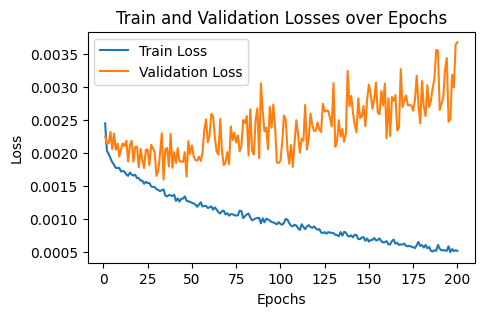

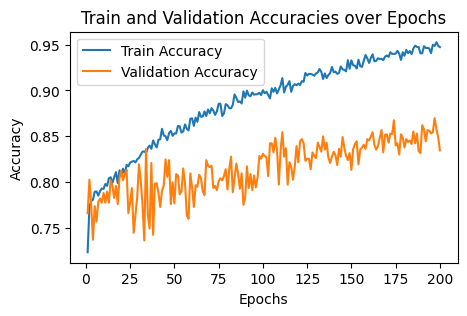

In [32]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH)
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH)

In [30]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/5000_Transformer_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 22.63it/s]

Best epoch: 197
macro F1 Score: 0.7780780273602431
AUROC: 0.871611978387234
Accuracy: 0.8576864535768646


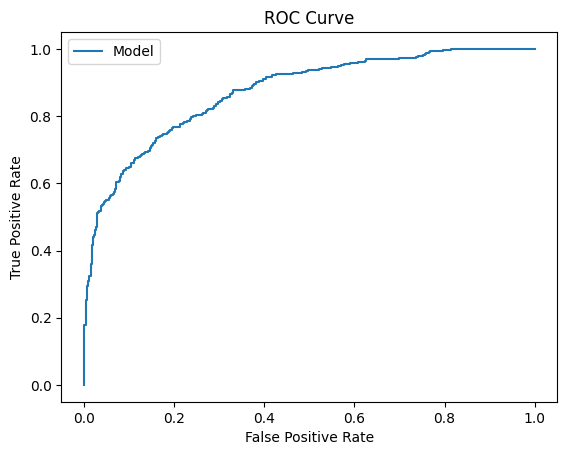

In [34]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)